# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.\
Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.\
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Задача**
 - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль
 - проанализировать возможную прибыль и риски техникой *Bootstrap*
 - после оценки рисков оставить лишь те регионы, в которых вероятность убытков меньше 2.5%
 - среди них выбрать регион с наибольшей средней прибылью

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений;
- Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## 1. Загрузка и подготовка данных

### 1.1. Импорт необходимых для работы библиотек, метрик и утилит

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# импорт моделей
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# метрики
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

# настройки
import warnings
warnings.filterwarnings("ignore")

# константа верхний регистр
RANDOM_STATE = 42

### 1.2. Загрузка исходных данных геологоразведки трёх регионов

In [2]:
# загрузим исходные данные
df_0 = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\geo_data_0.csv')
df_1 = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\geo_data_1.csv')
df_2 = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\geo_data_2.csv')

### 1.3. Описание данных
- **id** - уникальный идентификатор скважины
- **f0**, **f1**, **f2** - три признака точек (неважно, что они означают, но сами признаки значимы)
- **product** - объём запасов в скважине (тыс. баррелей)

In [3]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print("\nКоличество явных дубликатов:", data.duplicated().sum())

In [4]:
# общая информация о данных
get_info(df_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



Количество явных дубликатов: 0


In [5]:
# общая информация о данных
get_info(df_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



Количество явных дубликатов: 0


In [6]:
# общая информация о данных
get_info(df_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



Количество явных дубликатов: 0


### Выводы

1. Данные в ячейках соответствуют типу и описанию;
2. Пропуски и явные дубликаты не обнаружены;
3. Разброс значений довольно большой, поэтому на следующих шагах используем масштабирование;
4. Столбец **id** (уникальный идентификатор скважины) для исследования не потребуется и его можно удалить уже на этом этапе.

In [7]:
# удалим столбцы с уникальными данными, которые не повлияют на обучение модели
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

### 1.4. Построим гистограммы

#### 1.4.1. Регион №1

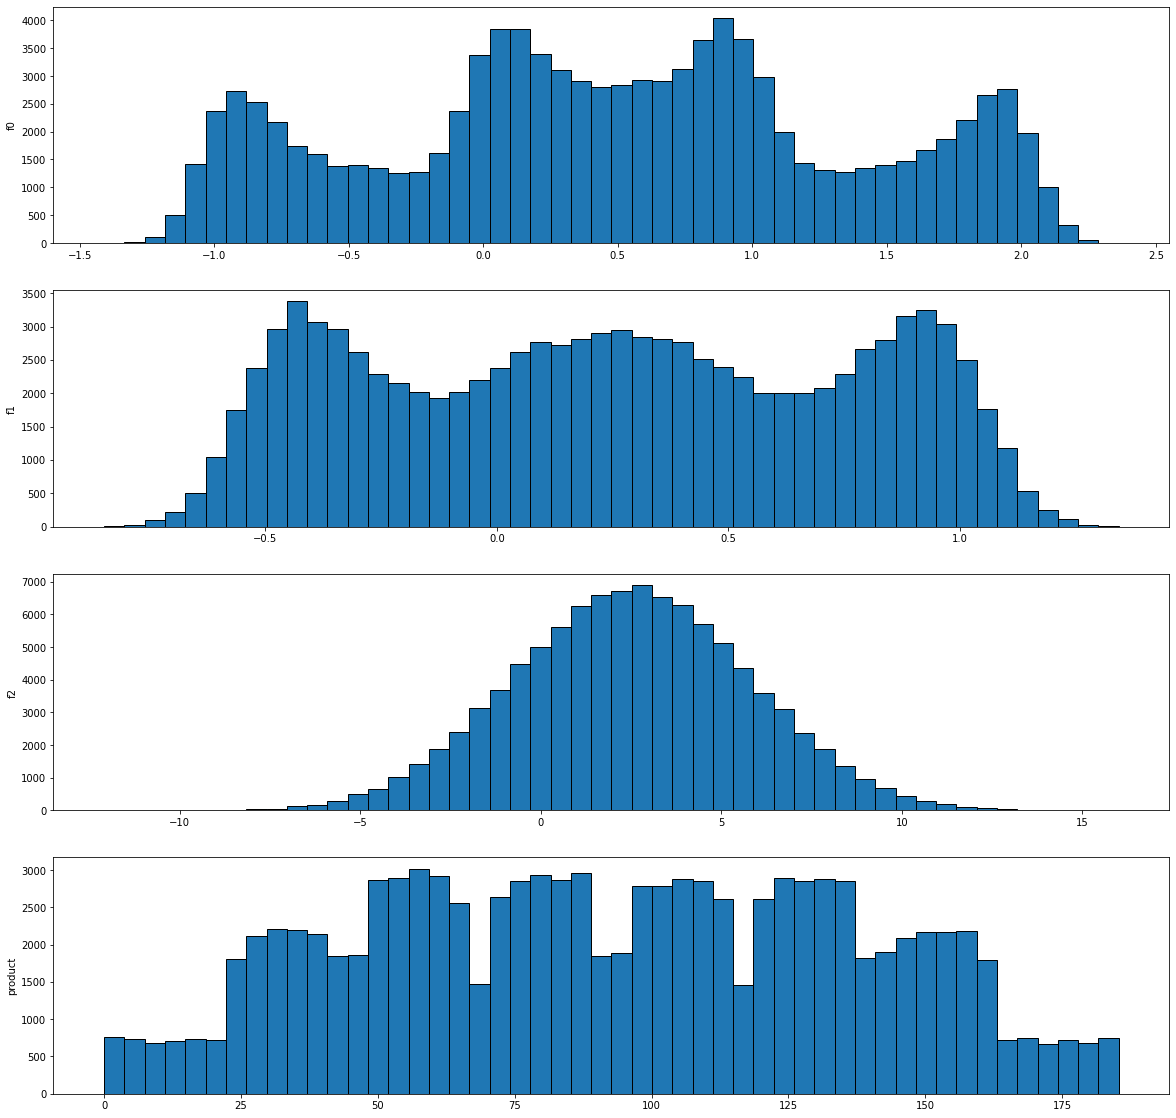

In [8]:
# отобразим данные на графиках
fig, axis = plt.subplots(4,1, figsize=(20,20))

n = 0
for column in df_0:
    df_0[df_0.columns[n]].plot.hist(ax=axis[0+n], edgecolor='black', linewidth=1, bins=50).set(ylabel=df_0.columns[n]);       
    n += 1

#### 1.4.2. Регион №2

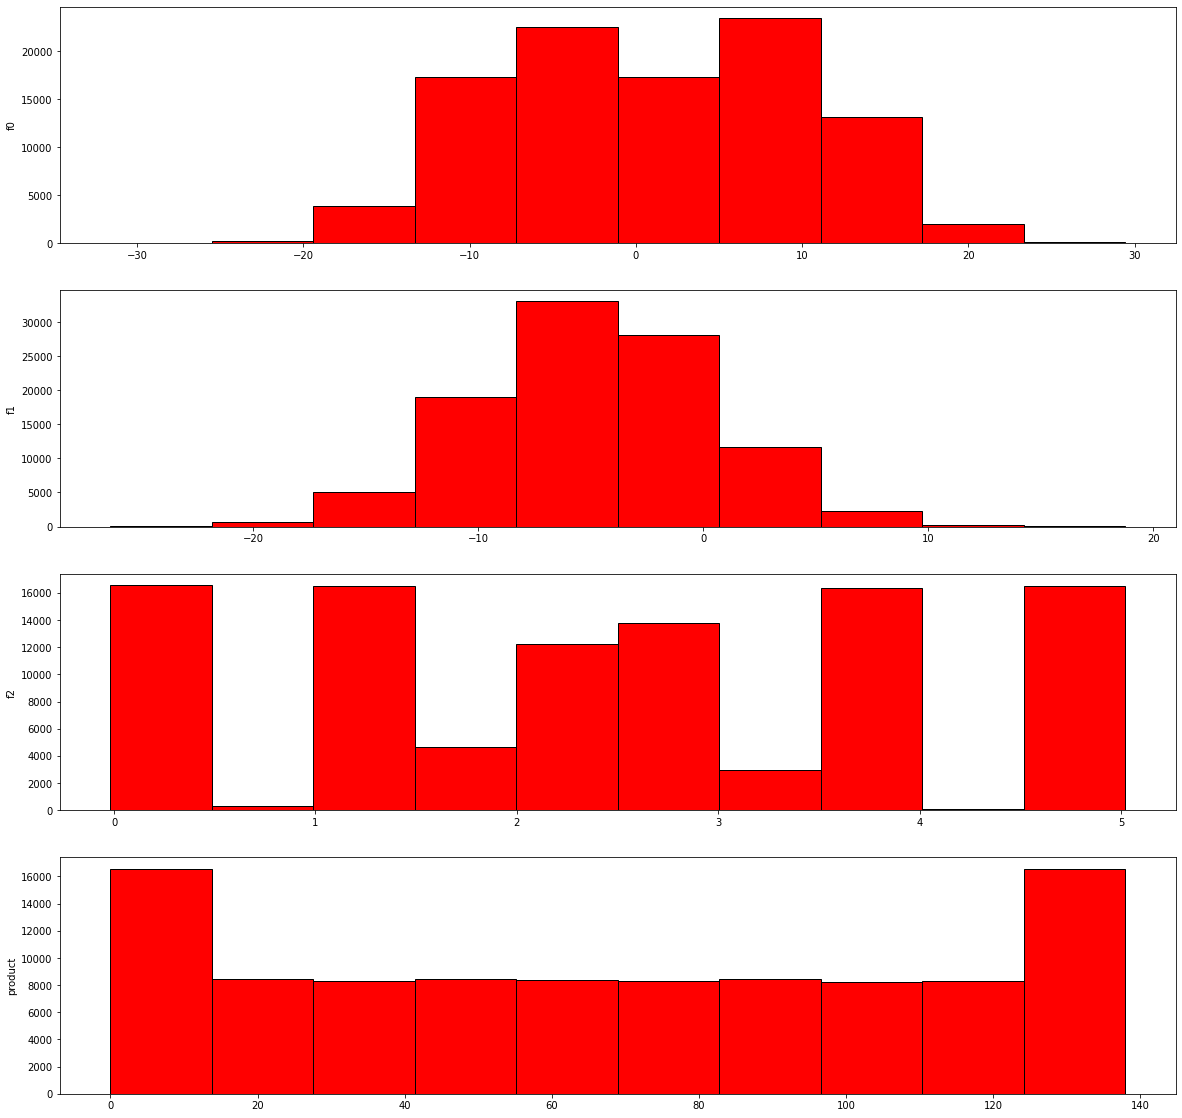

In [9]:
# отобразим данные на графиках
fig, axis = plt.subplots(4,1, figsize=(20,20))

n = 0
for column in df_1:
    df_1[df_1.columns[n]].plot.hist(ax=axis[0+n], color='r', edgecolor='black', linewidth=1, bins=10).set(ylabel=df_1.columns[n]);       
    n += 1

#### 1.4.3. Регион №3

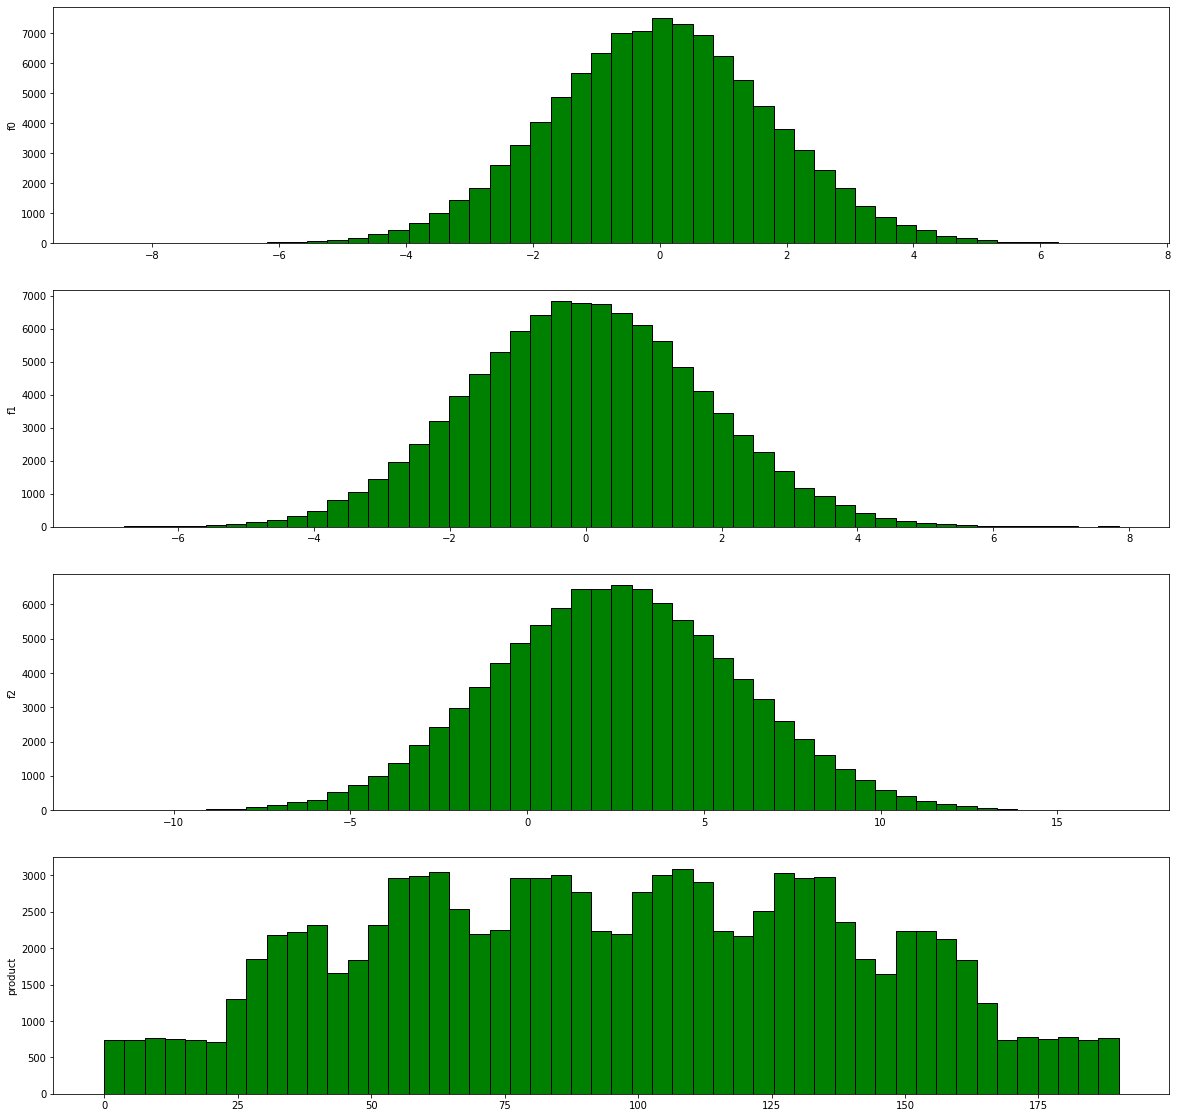

In [10]:
# отобразим данные на графиках
fig, axis = plt.subplots(4,1, figsize=(20,20))

n = 0
for column in df_0:
    df_2[df_2.columns[n]].plot.hist(ax=axis[0+n], color='g', edgecolor='black', linewidth=1, bins=50).set(ylabel=df_2.columns[n]);       
    n += 1

## Выводы

1. Выбросы и выраженные хвосты отсуствуют не наблюдаются;
2. Распределение признаков напоминает нормальное, с одной вершиной, плато и двумя вершинами.

## 2. Обучение и проверка модели для каждого региона

### 2.1. Разобьем данные на обучающую и валидационную выборки в соотношении 75:25

**Признаки**
- **f0** - значимый признак
- **f1** - значимый признак
- **f2** - значимый признак

**Целевой признак**
- **product** — объём запасов в скважине (тыс. баррелей)

- **train** - обучающая выборка (**75%** исходных данных)
- **valid** - валидационная выборка (**25%** исходных данных)

In [11]:
# функция для выделения признаков и разделения данных на выборки
# на вход передаем датасет, на выходе - выборки

def train_valid(data):

# извлекаем признаки и отдельно сохнаняем целевой признак   
    features = data.drop(['product'], axis=1) 
    target = data['product']                  

# делим данные на выборки    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

# выводим результат на экран    
    print ('Обучающая выборка', '\n', 'Признаки:',features_train.shape, '\n', 'Целевой признак:', target_train.shape, '\n', sep='')
    print ('Валидационная выборка', '\n', 'Признаки:',features_valid.shape, '\n', 'Целевой признак:', target_valid.shape, '\n', sep='')
    
    return features_train, features_valid, target_train, target_valid

In [12]:
# обучающая и валидационная выборки для региона №1
print('\033[1m'+'Регион №1'+'\033[0m')
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_valid(df_0)

Регион №1
Обучающая выборка
Признаки:(75000, 3)
Целевой признак:(75000,)

Валидационная выборка
Признаки:(25000, 3)
Целевой признак:(25000,)



In [13]:
# обучающая и валидационная выборки для региона №2
print('\033[1m'+'Регион №2'+'\033[0m')
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_valid(df_1)

Регион №2
Обучающая выборка
Признаки:(75000, 3)
Целевой признак:(75000,)

Валидационная выборка
Признаки:(25000, 3)
Целевой признак:(25000,)



In [14]:
# обучающая и валидационная выборки для региона №3
print('\033[1m'+'Регион №2'+'\033[0m')
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_valid(df_2)

Регион №2
Обучающая выборка
Признаки:(75000, 3)
Целевой признак:(75000,)

Валидационная выборка
Признаки:(25000, 3)
Целевой признак:(25000,)



#### 2.1.1. Масштабируем численные признаки для каждого набора выборок

In [15]:
# функция для масштабирования численных признаков
# на вход подаем признаки обучающие, валидационные и столбцы с численными признаками 

def scaled(features_train, features_valid, numeric):

# создадим объект структуры StandardScaler и обучим его на обучающих данных
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])

# изменённые наборы сохраним в переменных    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    return features_train, features_valid

In [16]:
# сохраним в numeric список численных признаков
numeric = ['f0', 'f1', 'f2']
# получим масштабированные данные для региона №1
features_train_0, features_valid_0 = scaled(features_train_0, features_valid_0, numeric)

In [17]:
# сохраним в numeric список численных признаков
numeric = ['f0', 'f1', 'f2']
# получим масштабированные данные для региона №2
features_train_1, features_valid_1 = scaled(features_train_1, features_valid_1, numeric)

In [18]:
# сохраним в numeric список численных признаков
numeric = ['f0', 'f1', 'f2']
# получим масштабированные данные для региона №3
features_train_2, features_valid_2 = scaled(features_train_2, features_valid_2, numeric)

### 2.2. Обучим модель и сделаем предсказания для Региона №1

In [19]:
# создадим модель LinearRegression и обучим её на тренировочной выборке
model_0 = LinearRegression() 
model_0.fit(features_train_0, target_train_0)  

# получим предсказания модели на валидационной выборке
predictions_valid_0 = model_0.predict(features_valid_0)  

# сохраним предсказания
predictions_valid_0 = pd.Series(predictions_valid_0)

# правильные ответы
target_valid_0 = pd.Series(target_valid_0).reset_index(drop=True)

# среднее количество сырья в скаважине по предсказаниям
mean_predict_product_0 = predictions_valid_0.mean()

# среднее количество разведанного сырья в скаважине
mean_real_product_0 = target_valid_0.mean()

# посчитаем значение метрики RMSE на валидационной выборке
result_0 = mean_squared_error(target_valid_0, predictions_valid_0)**0.5

### 2.3. Обучим модель и сделаем предсказания для Региона №2

In [20]:
# создадим модель LinearRegression и обучим её на тренировочной выборке
model_1 = LinearRegression() 
model_1.fit(features_train_1, target_train_1)  

# получим предсказания модели на валидационной выборке
predictions_valid_1 = model_1.predict(features_valid_1)  

# сохраним предсказания
predictions_valid_1 = pd.Series(predictions_valid_1)

# правильные ответы
target_valid_1 = pd.Series(target_valid_1).reset_index(drop=True)

# среднее количество сырья в скаважине по предсказаниям
mean_predict_product_1 = predictions_valid_1.mean()

# среднее количество разведанного сырья в скаважине
mean_real_product_1 = target_valid_1.mean()
                          
# посчитаем значение метрики RMSE на валидационной выборке
result_1 = mean_squared_error(target_valid_1, predictions_valid_1)**0.5

### 2.4. Обучим модель и сделаем предсказания для Региона №3

In [21]:
# создадим модель LinearRegression и обучим её на тренировочной выборке
model_2 = LinearRegression() 
model_2.fit(features_train_2, target_train_2)  

# получим предсказания модели на валидационной выборке
predictions_valid_2 = model_2.predict(features_valid_2)  

# сохраним предсказания
predictions_valid_2 = pd.Series(predictions_valid_2)

# правильные ответы
target_valid_2 = pd.Series(target_valid_2).reset_index(drop=True)

# среднее количество сырья в скаважине по предсказаниям
mean_predict_product_2 = predictions_valid_2.mean()

# среднее количество разведанного сырья в скаважине
mean_real_product_2 = target_valid_2.mean()

# посчитаем значение метрики RMSE на валидационной выборке
result_2 = mean_squared_error(target_valid_2, predictions_valid_2)**0.5

### 2.4. Напечатаем на экране RMSE модели и средний запас предсказанного сырья в каждом регионе

In [22]:
print('\033[1m'+'Регион №1'+'\033[0m', '\n', 'RMSE модели линейной регрессии на валидационной выборке: ', f'{result_0:.3f}' , '\n', sep='')
print('Средний запас предсказанного сырья: ', f'{mean_predict_product_0:.4f}', '\n', sep='')
print('Средний запас разведанного сырья: ', f'{mean_real_product_0:.4f}')

Регион №1
RMSE модели линейной регрессии на валидационной выборке: 37.757

Средний запас предсказанного сырья: 92.3988

Средний запас разведанного сырья:  92.3260


In [23]:
print('\033[1m'+'Регион №2'+'\033[0m', '\n', 'RMSE модели линейной регрессии на валидационной выборке: ', f'{result_1:.3f}' , '\n', sep='')
print('Средний запас предсказанного сырья: ', f'{mean_predict_product_1:.4f}', '\n', sep='')
print('Средний запас разведанного сырья: ', f'{mean_real_product_1:.4f}')

Регион №2
RMSE модели линейной регрессии на валидационной выборке: 0.890

Средний запас предсказанного сырья: 68.7129

Средний запас разведанного сырья:  68.7254


In [24]:
print('\033[1m'+'Регион №3'+'\033[0m', '\n', 'RMSE модели линейной регрессии на валидационной выборке: ', f'{result_2:.3f}' , '\n', sep='')
print('Средний запас предсказанного сырья: ', f'{mean_predict_product_2:.4f}', '\n', sep='')
print('Средний запас разведанного сырья: ', f'{mean_real_product_2:.4f}')

Регион №3
RMSE модели линейной регрессии на валидационной выборке: 40.146

Средний запас предсказанного сырья: 94.7710

Средний запас разведанного сырья:  95.1510


## Выводы 

1. Лучший показатель RMSE в Регионе №2, однако в нём наименьший средний объем сырья на одну скважину;
2. Регион №3 имеет высокий средний объем по сырью, но показатель RMSE хуже, чем в Регионах №1 и №2;
3. Регион №1 при достаточно высоких средних объемах сырья, на уровне Региона №3 и больше, чем в Регионе №1, имеет несколько лучший показатель RMSE по сравнению с Регионом №3.

## 3. Подготовка к расчёту прибыли

### 3.1. Сохраним ключевые значения для расчётов в отдельных переменных

**Условия:**
- Бюджет на разработку скважин в регионе — 10 млрд рублей
- Один баррель сырья приносит 450 рублей дохода в текущих ценах
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки

In [25]:
ESTIMATE = 10**10     # 10 в 10 степени = 10 млрд рублей - смета на разработку скважин в регионе
BARREL = 450*1000     # стоимость одного барреля в рублях 450 * 1000, так как объём запасов в скважине в тысячах баррелей
SPOT = 500            # при разведке региона исследуют 500 точек
BEST_SPOT = 200       # выбирают и разрабатывают лучшие 200 скважин

### 3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [26]:
# расходы на разработку одной скважины
cost = ESTIMATE / BEST_SPOT
f'{cost:,.2f} рублей'

'50,000,000.00 рублей'

In [27]:
# минимальный запас нефти в тыс. бареллей в одной скважине для выхода в "ноль"
stock = cost / BARREL
f'{stock:,.2f} тыс. баррелей'

'111.11 тыс. баррелей'

In [28]:
# минимальный запас нефти в тыс. бареллей в 200 лучших скважинах региона для достижения точки безубыточности
stock_region = stock * BEST_SPOT
f'{stock_region:,.2f} тыс. баррелей'

'22,222.22 тыс. баррелей'

In [29]:
print('Запас сырья в скважине для достижения точки безубыточности: ', f'{stock:,.2f}', 'тыс. баррелей')
print('Запас сырья в 200 лучших скважинах региона для достижения точки безубыточности: ', f'{stock_region:,.2f}', 'тыс. баррелей')

Запас сырья в скважине для достижения точки безубыточности:  111.11 тыс. баррелей
Запас сырья в 200 лучших скважинах региона для достижения точки безубыточности:  22,222.22 тыс. баррелей


### 3.3. Сравним полученный объём сырья со средним запасом в каждом регионе

In [30]:
# средний запас сырья в 200 скважинах в каждом регионе

reserve_0 = df_0['product'].mean()*BEST_SPOT
reserve_1 = df_1['product'].mean()*BEST_SPOT
reserve_2 = df_2['product'].mean()*BEST_SPOT

In [31]:
print('Средний запас сырья в 200 скважинах в Регионе 1: ', '\033[1m'+ f'{reserve_0:,.2f}' +'\033[0m', 'тыс. баррелей')
print('='*74)
print('Средний запас сырья в 200 скважинах в Регионе 2: ', '\033[1m'+ f'{reserve_1:,.2f}' +'\033[0m', 'тыс. баррелей')
print('='*74)
print('Средний запас сырья в 200 скважинах в Регионе 3: ', '\033[1m'+ f'{reserve_2:,.2f}' +'\033[0m', 'тыс. баррелей')

Средний запас сырья в 200 скважинах в Регионе 1:  18,500.00 тыс. баррелей
Средний запас сырья в 200 скважинах в Регионе 2:  13,765.00 тыс. баррелей
Средний запас сырья в 200 скважинах в Регионе 3:  19,000.00 тыс. баррелей


## Выводы 

1. Точка безубыточности (ТБУ): доходы от продажи сырья - расходы на разработку = 0;
2. Смета на разработку составляет 10 млрд. рублей;
3. В смету заложена разработка 200 скважин;
4. Чтобы достичь ТБУ, необходимо, чтобы запас сырья в одной скважине составлял не менее 111.11 тыс. баррелей, а в регионе не менее 22,222.22 тыс. баррелей на 200 скважин;
5. После оценки ТБУ и средних запасов сырья в регионах Регионы 1 и 3 представляются наиболее перспективными для разработки.

## 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [32]:
# функция для расчета прибыли по выбранным скважинам
def profit(predictions, target, spots):
# отбираем скважины с максимальными значениями предсказаний     
    max_predictions = predictions.sort_values(ascending=False)
# целевые значения объемов сырья в соответствии с предсказаниями лучших скважин   
    best_target_spot = target[max_predictions.index][:spots]
# считаем прибыль (количество сырья * стоимость) - расходы на разработку
    income = (best_target_spot.sum() * BARREL) - ESTIMATE
    return income

### Рассчитаем прибыль для полученного объёма сырья в каждом регионе

In [33]:
# прибыль для каждого региона (предсказания, целевые значения, количество лучших скважин)

res_0 = profit (predictions_valid_0, target_valid_0, BEST_SPOT)
res_1 = profit (predictions_valid_1, target_valid_1, BEST_SPOT)
res_2 = profit (predictions_valid_2, target_valid_2, BEST_SPOT)

In [34]:
print('Прибыль для полученного объема сырья в 200 лучших скважинах в Регионе 1:', '\033[1m'+ f'{res_0:,.0f}'+'\033[0m', 'рублей')
print('='*93)
print('Прибыль для полученного объема сырья в 200 лучших скважинах в Регионе 2:', '\033[1m'+ f'{res_1:,.0f}'+'\033[0m', 'рублей')
print('='*93)
print('Прибыль для полученного объема сырья в 200 лучших скважинах в Регионе 3:', '\033[1m'+ f'{res_2:,.0f}'+'\033[0m', 'рублей')

Прибыль для полученного объема сырья в 200 лучших скважинах в Регионе 1: 3,359,141,114 рублей
Прибыль для полученного объема сырья в 200 лучших скважинах в Регионе 2: 2,415,086,697 рублей
Прибыль для полученного объема сырья в 200 лучших скважинах в Регионе 3: 2,598,571,759 рублей


## 5. Расчёт прибыли и рисков для каждого региона

### 5.1. Используем технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

### 5.2. Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [35]:
# создадим объект RandomState() для создания случайных выборок
state = np.random.RandomState(RANDOM_STATE)

# функция для процедуры бутстреп с 1000 выборок, рассчета доверительного интервала 95% и риска убытков
def bootstrap(predictions, target):
# список для сохранения результатов
    values=[]
# сохраним количество быорок с убытком
    unprofit = 0
    for i in range(1000):
        target_sample = target.sample(SPOT, replace=True, random_state=state)      # создаем подвыборку целевых скважин на 500 скважин
        predictions_sample = predictions[target_sample.index]                      # предсказания объемов сырья в соответствии с целевыми показателями скважин
        revenue = profit(predictions_sample, target, BEST_SPOT)                    # считаем прибыль для 200 скважин
        if revenue < 0:                                                            # отдельно считаем отрицательную прибыль (убыток)
            unprofit +=1
        values.append(revenue)                                                     # сохраняем результат
    
    values = pd.Series(values)                                                     # для дальнейше работы сохраняем список в Series
    lower = values.quantile(0.025)                                                 # отделяем нижнюю границу интервала
    upper = values.quantile(0.975)                                                 # отделяем верхнюю границу интервала
    middle = values.mean()                                                         # считаем среднюю прибыль из интервала 
    risk = unprofit / 1000                                                         # оцениваем риск убытков
    return lower, upper, middle, risk

In [36]:
# делаем рассчет для региона №1
lower_0, upper_0, middle_0, risk_0 = bootstrap(predictions_valid_0, target_valid_0)

# делаем рассчет для региона №2
lower_1, upper_1, middle_1, risk_1 = bootstrap(predictions_valid_1, target_valid_1)

# делаем рассчет для региона №3
lower_2, upper_2, middle_2, risk_2 = bootstrap(predictions_valid_2, target_valid_2)

In [37]:
print('\033[1m'+'Регион №1'+'\033[0m')
print('='*65)
print('Средняя прибыль:',  '\033[1m'+ f'{middle_0:,.0f}'+'\033[0m', 'рублей')
print('='*65)
print('Доверительный интервал 95%:', 'от', '\033[1m'+ f'{lower_0:,.0f}'+'\033[0m', 'до', '\033[1m'+ f'{upper_0:,.0f}'+'\033[0m', 'рублей')
print('='*65)
print('Риск убытков:', '\033[1m'+ f'{risk_0:.2%}'+'\033[0m')

Регион №1
Средняя прибыль: 399,575,478 рублей
Доверительный интервал 95%: от -110,467,895 до 897,460,328 рублей
Риск убытков: 6.00%


In [38]:
print('\033[1m'+'Регион №2'+'\033[0m')
print('='*65)
print('Средняя прибыль:',  '\033[1m'+ f'{middle_1:,.0f}'+'\033[0m', 'рублей')
print('='*65)
print('Доверительный интервал 95%:', 'от', '\033[1m'+ f'{lower_1:,.0f}'+'\033[0m', 'до', '\033[1m'+ f'{upper_1:,.0f}'+'\033[0m', 'рублей')
print('='*65)
print('Риск убытков:', '\033[1m'+ f'{risk_1:.2%}'+'\033[0m')

Регион №2
Средняя прибыль: 452,576,594 рублей
Доверительный интервал 95%: от 52,309,410 до 830,146,313 рублей
Риск убытков: 0.90%


In [39]:
print('\033[1m'+'Регион №3'+'\033[0m')
print('='*65)
print('Средняя прибыль:',  '\033[1m'+ f'{middle_2:,.0f}'+'\033[0m', 'рублей')
print('='*65)
print('Доверительный интервал 95%:', 'от', '\033[1m'+ f'{lower_2:,.0f}'+'\033[0m', 'до', '\033[1m'+ f'{upper_2:,.0f}'+'\033[0m', 'рублей')
print('='*65)
print('Риск убытков:', '\033[1m'+ f'{risk_2:.2%}'+'\033[0m')

Регион №3
Средняя прибыль: 378,705,904 рублей
Доверительный интервал 95%: от -127,779,435 до 907,923,483 рублей
Риск убытков: 7.50%


## Выводы

1. Наибольшую среднюю прибыль, рассчитанную на 1000 выборок по технике Bootstrap показал Регион №2;
2. В Регионе №2 нижняя граница 95% доверительного интервала осталась в положительной зоне, то есть не вышла в убыток, в отличии от регионов №1 и №3;
3. Риск получения убытков при разработе скважин в Регионе №2 составил 0.9%, в регионах №1 и №3 - 6% и 7.5%, соответственно;
4. Модель LinearRegression выдала лучший показатель RMSE в Регионе №2;
5. Несмотря на то, что общий объем разведанных месторождений больше в регионах №1 и №3, мы можем с большей вероятностью выбрать лучшие скважины в Регионе №2.

Исходя из предложенных данных и проведенного исследования для дальнейшей разработки рекомендуется Регион №2.